In [2]:
import sys
sys.dont_write_bytecode = True
import pandas as pd
import pickle
import bz2
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import numpy as np
import marshal
import time
import collections
import os
import msgpack
from docker_agent_logger.app.src.AI import *

2024-02-11 16:25:03.462852: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-11 16:25:03.613500: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 16:25:03.613652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 16:25:03.639813: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-11 16:25:03.714245: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-11 16:25:03.716126: I tensorflow/core/platform/cpu_feature_guard.cc:1

Using TensorFlow backend


In [3]:
vocab_size = 5000

raw_ds = ( #.filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    tf.data.TextLineDataset("persistent_volume/data/BGL/BGL.log")
    .batch(128)
    .shuffle(buffer_size=256)
)

def parsing(data):
    # data = tf.strings.regex_replace(data, r'\b[a-zA-Z\d\-_\.]{20,}\b', '*')
    data = tf.strings.regex_replace(data, r".*RAS","")
    return data


ds = raw_ds.map(parsing, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
            ds,
            vocabulary_size=vocab_size,
            reserved_tokens=["[PAD]", "[UNK]","[BOS]","[EOS]"],
        )

with open("./docker_agent_logger/app/logs_tokenizer/vocab_parsed_bgl.pkl","wb") as f:
    pickle.dump(vocab,f)

2024-02-01 16:14:59.316583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22312 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [4]:
raw_ds = ( #.filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    tf.data.TextLineDataset("persistent_volume/data/BGL/BGL.log")
    # .batch(128)
    # .shuffle(buffer_size=256)
)

2024-02-01 18:23:15.003066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22312 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [4]:
for i in raw_ds.take(1000):
    print(i)

tf.Tensor(b'- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.363779 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected', shape=(), dtype=string)
tf.Tensor(b'- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.527847 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected', shape=(), dtype=string)
tf.Tensor(b'- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.675872 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected', shape=(), dtype=string)
tf.Tensor(b'- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.823719 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected', shape=(), dtype=string)
tf.Tensor(b'- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.982731 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected', shape=(), dtype=string)
tf.Tensor(b'- 1117838571 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.

In [5]:
def get_labels(data: tf.Tensor):
    data = data.decode("utf-8")
    if data[0] == "-":
        return (data[2:],False)
    else:
        return (data,True)
    
# ds = raw_ds.map(lambda x: tf.numpy_function(func=get_labels,inp=[x],Tout=(tf.string,tf.bool)), num_parallel_calls=tf.data.AUTOTUNE).prefetch(
#     tf.data.AUTOTUNE
# )
ds = raw_ds.map(lambda x: tf.numpy_function(func=get_labels,inp=[x],Tout=(tf.string,tf.bool)), num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

In [11]:
with open("docker_agent_logger/app/logs_tokenizer/vocab_parsed_bgl.pkl","rb") as f:
    vocab = pickle.load(f)

tokenizer = Tokenizer(vocab,)

ds_parsed = ds.map(lambda x,y: (tf.strings.regex_replace(x, r".*RAS",""),y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

ds_tokenized = ds_parsed.map(lambda x,y: (tokenizer.tokenizer(x),y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

for i in ds_tokenized.take(2):
    print(i,len(i[0].numpy()[0]))

(<tf.RaggedTensor [[90, 91, 127, 150, 152, 104, 122]]>, <tf.Tensor: shape=(), dtype=bool, numpy=False>) 7
(<tf.RaggedTensor [[90, 91, 127, 150, 152, 104, 122]]>, <tf.Tensor: shape=(), dtype=bool, numpy=False>) 7


In [12]:
#get max len, mean len and std len 
seq_lens = []
for i in ds_tokenized:
    seq_lens.append(len(i[0].numpy()[0]))

seq_lens = np.array(seq_lens)
print(seq_lens.max())
print(seq_lens.mean())
print(seq_lens.std())
print(seq_lens.min())
print(len(seq_lens))

230
13.908248863775897
15.522431647047322
2
4747963


In [29]:
vocab_size = 5000
max_len=20
epochs=8
chkpt = "docker_agent_logger/app/classifier_bgl_filtered_parsed/"
MAN_TRAINING_SEQ_LEN = 1000

raw_ds = (
    tf.data.TextLineDataset("persistent_volume/data/BGL/BGL.log")
    # .filter(lambda x: tf.strings.length(x) < MAN_TRAINING_SEQ_LEN)
    # .batch(128)
    # .shuffle(buffer_size=256)
)

# vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
#             raw_ds,
#             vocabulary_size=vocab_size,
#             reserved_tokens=["[PAD]", "[UNK]", "[BOS]","[EOS]"],
#         )

# with open("docker_agent_logger/app/logs_tokenizer/vocab.pkl","wb") as f:
#     pickle.dump(vocab,f)

with open("docker_agent_logger/app/logs_tokenizer/vocab_parsed_bgl.pkl","rb") as f:
    vocab = pickle.load(f)

tokenizer = Tokenizer(vocab=vocab,max_len=max_len)

def get_labels(data: tf.Tensor):
    data = data.decode("utf-8")
    if data[0] == "-":
        return (data[2:],False)
    else:
        return (data,True)
    



ds = raw_ds.map(lambda x: tf.numpy_function(func=get_labels,inp=[x],Tout=(tf.string,tf.bool)), num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

# ds_tokenized = ds.map(lambda x,y: (tf.numpy_function(func=tokenizer.vectorization,inp=[x],Tout=tf.int32),y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(
#     tf.data.AUTOTUNE
# )
ds_tokenized = ds.map(lambda x,y: (tokenizer.vectorization(x)[0],y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)



val_split = 0.2
ds_size = 4747963

train_size = int((1-val_split) * ds_size)
val_size = int(val_split * ds_size)

train_size = 3496193

train_ds = ds.take(train_size).filter(lambda x,y: y == False)
train_ds = train_ds.map(lambda x,y: (tf.strings.regex_replace(x, r".*RAS",""),y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
train_ds = train_ds.map(lambda x,y: tokenizer.vectorization(x)[0], num_parallel_calls=tf.data.AUTOTUNE).batch(128)
# train_ds = train_ds.shuffle(buffer_size=train_size).batch(128)
val_ds = ds.skip(train_size).take(val_size)



model = Model(vocab_size = vocab_size,latent_dim=int(max_len/1.4),embedding_dim=128,max_len = max_len)

# model.vae.load_model(chkpt=chkpt) #17 for the other model

model.train_model(train_ds,epochs=epochs,chkpt=chkpt)






Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 20)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_embedding (TokenAndP  (None, 20, 128)              642560    ['input_word_ids[0][0]']      
 ositionEmbedding)                                                                                
                                                                                                  
 encoding (TransformerEncod  (None, 20, 128)              70286     ['input_embedding[0][0]']     
 er)                                                                                        

2024-02-02 11:33:43.401720: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4518028029867270536
2024-02-02 11:33:43.401760: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 17284400436348715402
2024-02-02 11:33:43.401767: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 18373329185532312023
2024-02-02 11:33:43.401796: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16245741290533778366
2024-02-02 11:33:43.401801: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 1925569710002213742
2024-02-02 11:33:43.401804: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4156047909177345500
2024-02-02 11:33:43.401808: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

Epoch 2/8
25054/25054 [==============================] - 479s 19ms/step - total_loss: 57.6523 - reconstruction_loss: 54.9042 - kl_loss: 6.3474e-05
Epoch 3/8
25054/25054 [==============================] - 479s 19ms/step - total_loss: 57.0719 - reconstruction_loss: 54.1486 - kl_loss: 2.6519e-05
Epoch 4/8
25054/25054 [==============================] - 479s 19ms/step - total_loss: 57.6581 - reconstruction_loss: 54.4006 - kl_loss: 1.5671e-05
Epoch 5/8
25054/25054 [==============================] - 479s 19ms/step - total_loss: 59.3661 - reconstruction_loss: 55.8220 - kl_loss: 1.0990e-05
Epoch 6/8
25054/25054 [==============================] - 477s 19ms/step - total_loss: 59.8426 - reconstruction_loss: 56.6374 - kl_loss: 8.1516e-06
Epoch 7/8
25054/25054 [==============================] - 476s 19ms/step - total_loss: 59.9247 - reconstruction_loss: 56.8005 - kl_loss: 6.6485e-06
Epoch 8/8
25054/25054 [==============================] - 475s 19ms/step - total_loss: 59.9695 - reconstruction_loss: 5

In [23]:
from docker_agent_reader.app.src.AI_rnd import *

In [19]:
print(train_size)

3798370


In [22]:
count = 0
for i in train_ds.batch(128):
    count += 128
print(count)

3496320


In [ ]:
for i in val_ds.take(1):
    print(i)

In [ ]:
for i in ds_tokenized.batch(10).take(1):
    print(i)

10.43422


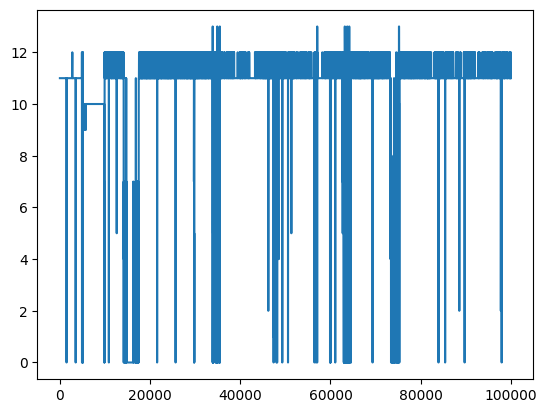

In [30]:
#counting mean padding

ds_parsed = ds.map(lambda x,y: (tf.strings.regex_replace(x, r".*RAS",""),y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

ds_tokenized = ds_parsed.map(lambda x,y: tokenizer.vectorization(x)[0], num_parallel_calls=tf.data.AUTOTUNE)

pad = []
for data in ds_tokenized.take(100000).batch(1):
    pad.append(tf.reduce_sum(tf.cast(tf.equal(data,0),tf.int32)).numpy())
plt.plot(pad)
print(np.mean(pad))


In [24]:
with open("sample_logs.txt","w") as f:
    for logs in raw_ds.skip(train_size).take(5000).batch(1):
        f.write(logs.numpy()[0].decode("utf-8")+"\n")

In [5]:
#keep a dataset with an anomaly rate of 1%
with open("test_set_bgl.txt","a") as f:
    count = 0
    anomalies = 0
    for logs in val_ds.take(949592//3).batch(1):
        count += 1
        if logs[1].numpy()[0] == True:
            anomalies += 1
            f.write(logs[0].numpy()[0].decode("utf-8")+"\n")
        else:
            if anomalies/count > 0.01:
                f.write("- "+logs[0].numpy()[0].decode("utf-8")+"\n")


In [19]:
raw_ds = (
    tf.data.TextLineDataset("persistent_volume/data/BGL/test_set_bgl.txt")
    # .filter(lambda x: tf.strings.length(x) < MAN_TRAINING_SEQ_LEN)
    # .batch(128)
    # .shuffle(buffer_size=256)
)

ds = raw_ds.map(lambda x: tf.numpy_function(func=get_labels,inp=[x],Tout=(tf.string,tf.bool)), num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

for i in ds.take(3).batch(1):
    print(i)

(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'KERNNOETH 1131113126 2005.11.04 R70-M0-N4-I:J18-U11 2005-11-04-06.05.26.826558 R70-M0-N4-I:J18-U11 RAS KERNEL FATAL no ethernet link'],
      dtype=object)>, <tf.Tensor: shape=(1,), dtype=bool, numpy=array([ True])>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'KERNMC 1131143766 2005.11.04 R35-M1-NA-C:J08-U01 2005-11-04-14.36.06.220414 R35-M1-NA-C:J08-U01 RAS KERNEL FATAL machine check interrupt'],
      dtype=object)>, <tf.Tensor: shape=(1,), dtype=bool, numpy=array([ True])>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'KERNRTSP 1131143822 2005.11.04 R35-M1-NA-C:J08-U01 2005-11-04-14.37.02.170925 R35-M1-NA-C:J08-U01 RAS KERNEL FATAL rts panic! - stopping execution'],
      dtype=object)>, <tf.Tensor: shape=(1,), dtype=bool, numpy=array([ True])>)


In [ ]:
print(data)

In [51]:
print(val_size)

949592


In [ ]:
for log in train_ds.take(10).batch(1):
    print(log)
    print(model.vae.get_loss(log))


In [36]:
vocab_size = 5000
max_len=20
latent_dim=int(max_len/1.4)
chkpt = "docker_agent_logger/app/classifier_bgl_filtered_parsed/7"

data = {"logs":[],"parsed_logs":[],"vectorized_logs":[],"encoded_logs":[]}
times = {"parsed_logs":[],"vectorized_logs":[],"encoded_logs":[],"anomaly":[],"anomaly_rnd":[]}
recostruction_loss = []
threshold = 530

with open("docker_agent_logger/app/logs_tokenizer/vocab_bgl.pkl","rb") as f:
    vocab = pickle.load(f)
tokenizer = Tokenizer(vocab=vocab,max_len=max_len)

model = Model(vocab_size = vocab_size,latent_dim=latent_dim,embedding_dim=128,max_len = max_len)

model.vae.load_model(chkpt=chkpt) #17 for the other model

FP_rec = []
TP_rec = []
FN_rec = []
TN_rec = []

def get_labels(data: tf.Tensor):
    data = data.decode("utf-8")
    if data[0] == "-":
        return (data[2:],False)
    else:
        return (data,True)


raw_ds = (
    tf.data.TextLineDataset("persistent_volume/data/BGL/test_set_bgl.txt")
    # .filter(lambda x: tf.strings.length(x) < MAN_TRAINING_SEQ_LEN)
    # .batch(128)
    # .shuffle(buffer_size=256)
)
ds = raw_ds.map(lambda x: tf.numpy_function(func=get_labels,inp=[x],Tout=(tf.string,tf.bool)), num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)
ds_labeled = ds.map(lambda x,y: (tf.strings.regex_replace(x, r".*RAS",""),y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)



for logs in ds_labeled.take(30000).batch(1):
    # t = time.time()
    # parsed_logs = tokenizer.parsing(logs)   
    t_parse = time.time()
    # times["parsed_logs"].append(t_parse-t)
    vectorized_logs = tokenizer.vectorization(logs[0])
    t_vectorize = time.time()
    times["vectorized_logs"].append(t_vectorize-t_parse)
    encoded_logs = model.vae.encode(vectorized_logs)
    t_encode = time.time()
    times["encoded_logs"].append(t_encode-t_vectorize)
    loss = model.vae.get_loss(vectorized_logs)

    anomaly = logs[1].numpy()[0]
    if loss > threshold:
        if anomaly:
            TP_rec.append(logs[0].numpy()[0].decode("utf-8"))
        else:
            FP_rec.append(logs[0].numpy()[0].decode("utf-8"))
    else:
        if anomaly:
            FN_rec.append(logs[0].numpy()[0].decode("utf-8"))
        else:
            TN_rec.append(logs[0].numpy()[0].decode("utf-8"))
    
    t_anomaly = time.time()
    times["anomaly"].append(t_anomaly-t_encode)

    # recostruction_loss_rnd_value, anomaly_rnd = anomaly_detector.detect(encoded_logs,thresholds_rnd[-1])

    # if anomaly_rnd:
    #     if anomaly:
    #         TP_rnd.append(logs[0].numpy()[0].decode("utf-8"))
    #     else:
    #         FP_rnd.append(logs[0].numpy()[0].decode("utf-8"))
    # else:
    #     if anomaly:
    #         FN_rnd.append(logs[0].numpy()[0].decode("utf-8"))
    #     else:
    #         TN_rnd.append(logs[0].numpy()[0].decode("utf-8"))

    # d_rnd.append(recostruction_loss_rnd_value.numpy())
    # thresholds_rnd.append(np.percentile(d_rnd,percentile))
    

    # times["anomaly_rnd"].append(time.time()-t_anomaly)

    # anomaly_detector.train_step(encoded_logs)


    # recostruction_loss_rnd.append(recostruction_loss_rnd_value.numpy())
    recostruction_loss.append(loss)
    compressed_data = bz2.compress(pickle.dumps(logs))
    data["logs"].append(sys.getsizeof(compressed_data))
    # compressed_data = bz2.compress(pickle.dumps(parsed_logs))
    # data["parsed_logs"].append(sys.getsizeof(compressed_data))
    compressed_data = bz2.compress(pickle.dumps(vectorized_logs))
    data["vectorized_logs"].append(sys.getsizeof(compressed_data))
    compressed_data = bz2.compress(pickle.dumps(encoded_logs))
    data["encoded_logs"].append(sys.getsizeof(compressed_data))

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 20)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_embedding (TokenAndP  (None, 20, 128)              642560    ['input_word_ids[0][0]']      
 ositionEmbedding)                                                                                
                                                                                                  
 encoding (TransformerEncod  (None, 20, 128)              70286     ['input_embedding[0][0]']     
 er)                                                                                        

In [ ]:
data

In [ ]:
times

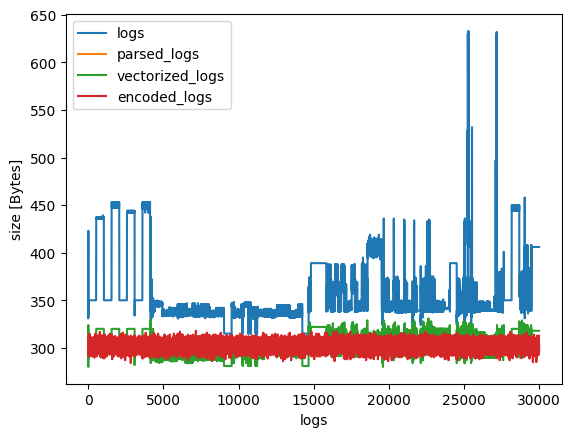

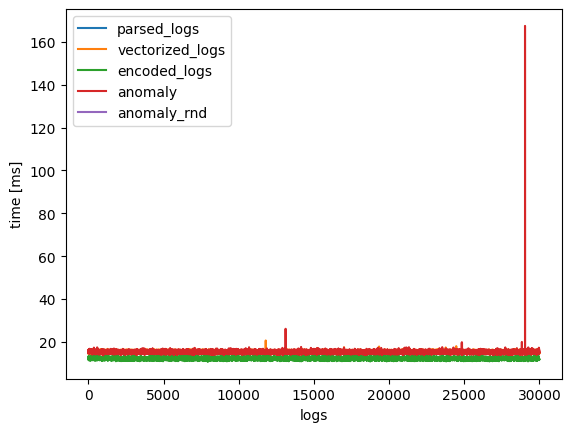

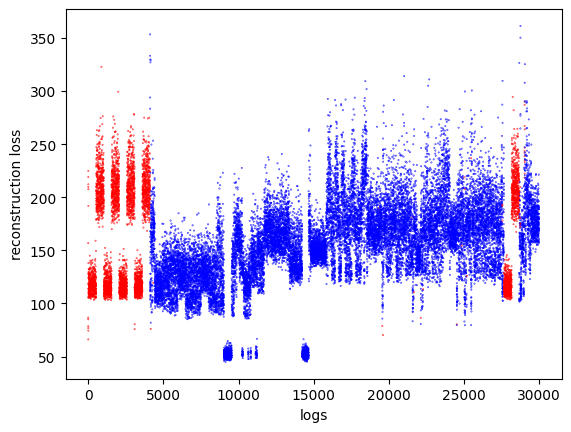

In [37]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots()
for key in data.keys():
    ax.plot(data[key], label=key)
    plt.xlabel('logs')
    plt.ylabel('size [Bytes]')
    plt.legend()

fig.savefig("data/size.png")

fig, ax = plt.subplots()
for key in times.keys():
    ax.plot(np.array(times[key][10:])*10**3, label=key)
    plt.xlabel('logs')
    plt.ylabel('time [ms]')
    plt.legend()

fig.savefig("data/time.png")

c = np.array(list((ds.batch(1).map(lambda x,y: int(y[0])).take(len(recostruction_loss)).as_numpy_iterator())))

fig, ax = plt.subplots()
# ax.plot(thresholds)
cmap = ListedColormap(["blue","red"])
ax.scatter([i for i in range(len(recostruction_loss))],recostruction_loss, c = c,cmap = cmap,s=0.1)
# ax.scatter(recostruction_loss)
plt.xlabel('logs')
plt.ylabel('reconstruction loss')

fig.savefig("data/reconstruction_loss.png")

# fig, ax = plt.subplots()
# # ax.plot(thresholds_rnd)
# ax.scatter([i for i in range(len(recostruction_loss_rnd))],recostruction_loss_rnd, c = c,cmap = cmap,s=0.1)
# # ax.plot(recostruction_loss_rnd)
# plt.xlabel('logs')
# plt.ylabel('reconstruction loss rnd')

# plt.savefig("data/reconstruction_loss_rnd.png")



plt.show()

In [7]:
with open("data/anomalies.txt","w") as f:
    f.write("true anomalies: {}\n".format(len(TP_rec)+len(FN_rec)))
    f.write("false labeled anomalies: {}\n".format(len(FP_rec)))
    f.write("true labeled anomalies: {}\n".format(len(TP_rec)))
    f.write("precision: {}\n".format(len(TP_rec)/(len(TP_rec)+len(FP_rec))))
    f.write("accuracy: {}\n".format((len(TP_rec)+len(TN_rec))/(len(TP_rec)+len(TN_rec)+len(FP_rec)+len(FN_rec))))
    f.write("F1-score: {}\n".format(2*len(TP_rec)/(2*len(TP_rec)+len(FP_rec)+len(FN_rec))))
    # f.write("false labeled anomalies rnd: {}\n".format(len(FP_rnd)))
    # f.write("true labeled anomalies rnd: {}\n".format(len(TP_rnd)))
    # f.write("precision rnd: {}\n".format(len(TP_rnd)/(len(TP_rnd)+len(FP_rnd))))
    # f.write("accuracy rnd: {}\n".format((len(TP_rnd)+len(TN_rnd))/(len(TP_rnd)+len(TN_rnd)+len(FP_rnd)+len(FN_rnd))))
    # f.write("F1-score rnd: {}\n".format(2*len(TP_rnd)/(2*len(TP_rnd)+len(FP_rnd)+len(FN_rnd))))

    f.write("true anomalies:\n")
    for i in TP_rec+FN_rec:
        f.write(i+"\n")
    f.write("false labeled anomalies:\n")
    for i in FP_rec:
        f.write(i+"\n")
    f.write("true labeled anomalies:\n")
    for i in TP_rec:
        f.write(i+"\n")
    # f.write("false labeled anomalies rnd:\n")
    # for i in FP_rnd:
    #     f.write(i+"\n")
    # f.write("true labeled anomalies rnd:\n")
    # for i in TP_rnd:
    #     f.write(i+"\n")

    

ZeroDivisionError: division by zero

In [ ]:
# z = tf.random.normal(shape=(1,60 ,30),dtype=tf.float32)
encode_token = val_ds.take(1).batch(1).as_numpy_iterator().next()

print(encode_token)


z = model.vae.encoder(tokenizer.preprocess(encode_token))[0]

tokens = model.vae.decode(z)

print((tokenizer.decode(tokens).numpy()))


In [ ]:
def plot_label_clusters(vae, name,data):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    # plt.savefig("./results/"+name+".png")
    plt.show()

# model = Model(vocab_size = vocab_size,latent_dim=256,embedding_dim=128,max_len = max_len)


# for i in range(32):
#     model.vae.load_model(chkpt=chkpt+str(i))

#     plot_label_clusters(model.vae, "cluster"+str(i),ds)

ds_val_pre = val_ds.map(tokenizer.preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

plot_label_clusters(model.vae, "cluster"+str(17),ds_val_pre.take(10000).batch(128))

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 85)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_embedding (TokenAndP  (None, 85, 128)              650880    ['input_word_ids[0][0]']      
 ositionEmbedding)                                                                                
                                                                                                  
 encoding (TransformerEncod  (None, 85, 128)              77482     ['input_embedding[0][0]']     
 er)                                                                                        

/home/lucaserf/anaconda3/envs/obs-env/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/lucaserf/anaconda3/envs/obs-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


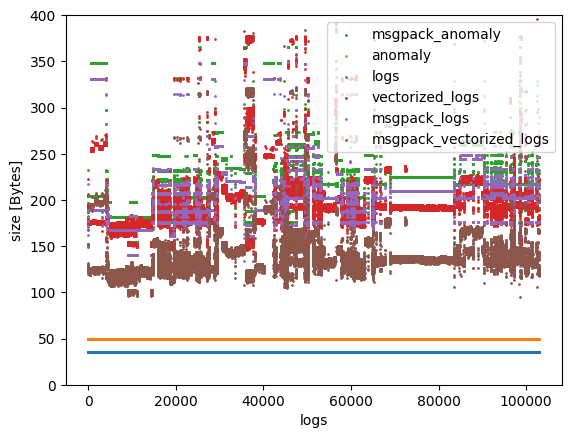

In [13]:
#testing sizes with compression or not
vocab_size = 5000
max_len=85 # mean length + std length
latent_dim=max_len//2

chkpt = "docker_agent_logger/app/trained_classifier/15"

with open("docker_agent_logger/app/logs_tokenizer/vocab_bgl.pkl","rb") as f:
    vocab = pickle.load(f)

tokenizer = Tokenizer(vocab=vocab,max_len=max_len)

model = Model(vocab_size = vocab_size,latent_dim=latent_dim,embedding_dim=128,max_len = max_len)

model.vae.load_model(chkpt=chkpt) 

data = {"msgpack_anomaly":[],"anomaly":[],"logs":[],"vectorized_logs":[],"msgpack_logs":[],"msgpack_vectorized_logs":[]}


def get_labels(data: tf.Tensor):
    data = data.decode("utf-8")
    if data[0] == "-":
        return (data[2:],False)
    else:
        return (data,True)


raw_ds = (
    tf.data.TextLineDataset("persistent_volume/data/BGL/test_set_bgl.txt")
    # .filter(lambda x: tf.strings.length(x) < MAN_TRAINING_SEQ_LEN)
    # .batch(128)
    # .shuffle(buffer_size=256)
)
ds = raw_ds.map(lambda x: tf.numpy_function(func=get_labels,inp=[x],Tout=(tf.string,tf.bool)), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


for logs in ds.batch(1):
    logs = logs[0]
    logs = logs.numpy().tolist()
    data["logs"].append(sys.getsizeof(pickle.dumps(logs)))
    # data["compressed_logs"].append(sys.getsizeof(bz2.compress(pickle.dumps(logs))))
    data["msgpack_logs"].append(sys.getsizeof(msgpack.packb(logs)))
    vectorized_logs = tokenizer.tokenizer(logs).numpy()
    vectorized_logs = [vl.tolist() for vl in vectorized_logs]
    data["vectorized_logs"].append(sys.getsizeof(pickle.dumps(vectorized_logs)))
    # data["compressed_vectorized_logs"].append(sys.getsizeof(bz2.compress(pickle.dumps(vectorized_logs))))
    data["msgpack_vectorized_logs"].append(sys.getsizeof(msgpack.packb(vectorized_logs)))
    anomaly = [False]
    data["anomaly"].append(sys.getsizeof(pickle.dumps(anomaly)))
    data["msgpack_anomaly"].append(sys.getsizeof(msgpack.packb(anomaly)))

# print(logs)
# print(vectorized_logs)
# print(anomaly)

fig, ax = plt.subplots()
for key in data.keys():
    # ax.plot(data[key], label=key)
    x = [i for i in range(len(data[key]))]
    y = data[key]
    ax.scatter(x,y,s=1,zorder=1,label=key)

plt.ylim(0, 400)
plt.xlabel('logs')
plt.ylabel('size [Bytes]')
plt.legend()




In [14]:
print(np.mean(data["logs"]))
print(np.mean(data["msgpack_logs"]))
print(np.mean(data["vectorized_logs"]))
print(np.mean(data["msgpack_vectorized_logs"]))
print(np.mean(data["anomaly"]))
print(np.mean(data["msgpack_anomaly"]))


226.58829242708262
211.47216853310542
199.81484862906595
143.47731621324994
49.0
35.0


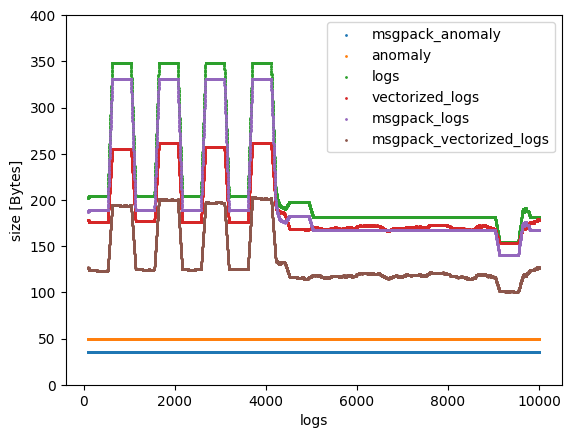

In [22]:
fig, ax = plt.subplots()
for key in data.keys():
    # ax.plot(data[key], label=key)
    y = pd.Series(data[key][:10000]).rolling(window=100).mean()
    x = [i for i in range(len(y))]
    
    ax.scatter(x,y,s=1,zorder=1,label=key)

plt.ylim(0, 400)
plt.xlabel('logs')
plt.ylabel('size [Bytes]')
plt.legend()